In [1]:
import datetime
import logging
import time

import numpy as np
import pandas as pd
import torch
from lightning import Trainer, seed_everything
from matplotlib import pyplot as plt
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity

from dal_toolbox.active_learning import ActiveLearningDataModule
from dal_toolbox.active_learning.strategies import Query
from dal_toolbox.active_learning.strategies.typiclust import kmeans
from dal_toolbox.active_learning.strategies.xpal import xpal_gain
from dal_toolbox.datasets.utils import FeatureDatasetWrapper
from dal_toolbox.metrics import Accuracy, BrierScore, ExpectedCalibrationError, AdaptiveCalibrationError
from dal_toolbox.models.deterministic import DeterministicModel
from dal_toolbox.models.deterministic.linear import LinearModel
from dal_toolbox.models.parzen_window_classifier import PWCLightning
from dal_toolbox.utils import _calculate_mean_gamma, kernels

logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

/mnt/stud/home/ynagel/dal-toolbox/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class XPALClust(Query):
    MIN_CLUSTER_SIZE = 5
    MAX_NUM_CLUSTERS = 500
    K_NN = 20

    def __init__(self, num_classes, S, alpha_c, alpha_x, subset_size=None, random_seed=None):
        super().__init__(random_seed)

        self.num_classes = num_classes
        self.S = S
        self.alpha_c_ = alpha_c
        self.alpha_x_ = alpha_x
        self.subset_size = subset_size

    def query(self, *, model, clust_al_datamodule, xpal_al_datamodule, xpalclustswitch_al_datamodule, acq_size, gamma, switch, **kwargs):
        """Compute score for each unlabeled sample. Score is to be maximized.
        Parameters
        ----------
        unlabeled_indices: array-like, shape (n_unlabeled_samples)
        Returns
        -------
        scores: array-like, shape (n_unlabeled_samples)
            Score of each unlabeled sample.
        """
        # compute frequency estimates for evaluation set (K_x) and candidate set (K_c)
        strategies = ["xpal", "xpalclust", "xpalclustswitch"]
        metrics = {"xpal": {}, "xpalclust": {}, "xpalclustswitch": {}}
        if "xpal" in strategies:
            unlabeled_dataloader, unlabeled_indices = xpal_al_datamodule.unlabeled_dataloader(subset_size=self.subset_size)
            labeled_loader, labeled_indices = xpal_al_datamodule.labeled_dataloader()



            if self.subset_size is None:
                S_ = self.S

                mapped_labeled_indices = labeled_indices
                mapped_unlabeled_indices = unlabeled_indices
            else:
                # Deletes entries from S, that are not part of the labeled/unlabeled subset
                existing_indices = np.concatenate([unlabeled_indices, labeled_indices])
                indices_to_remove = np.arange(self.S.shape[0])
                mask = np.equal.outer(indices_to_remove, existing_indices)
                indices_to_remove = indices_to_remove[~np.logical_or.reduce(mask, axis=1)]

                S_ = np.delete(self.S, indices_to_remove, 0)
                S_ = np.delete(S_, indices_to_remove, 1)

                # Remapping indices
                mapping = np.argsort(np.argsort(existing_indices))
                mapped_labeled_indices = mapping[len(unlabeled_indices):]
                mapped_unlabeled_indices = mapping[:len(unlabeled_indices)]

            y_labeled = []

            for batch in labeled_loader:
                y_labeled.append(batch[1])
            if len(y_labeled) > 0:
                y_labeled = torch.cat(y_labeled).tolist()

            Z = np.eye(self.num_classes)[y_labeled]
            K_x = S_[:, mapped_labeled_indices] @ Z
            K_c = K_x[mapped_unlabeled_indices]

            # calculate loss reduction for each unlabeled sample
            gains = xpal_gain(K_c=K_c, K_x=K_x, S=S_[mapped_unlabeled_indices], alpha_c=self.alpha_c_,
                              alpha_x=self.alpha_x_)

            top_gains, xpal_indices = torch.topk(torch.Tensor(gains), acq_size)
            xpal_actual_indices = [int(unlabeled_indices[i]) for i in xpal_indices]

            unlabeled_features = model.get_representations(unlabeled_dataloader)

            top_gains = np.array(top_gains)
            metrics["xpal"]["max_gain"] = top_gains.max()
            metrics["xpal"]["min_gain"] = top_gains.min()
            metrics["xpal"]["mean_gain"] = top_gains.mean()
            metrics["xpal"]["entropy_gain"] = -np.sum(top_gains * np.log2(top_gains))

            chosen_features = unlabeled_features[xpal_indices]
            feature_gram_matrix = chosen_features.T @ chosen_features
            metrics["xpal"]["gram_determinant"] = np.linalg.det(feature_gram_matrix)
            metrics["xpal"]["gram_log_determinant"] = np.log(np.linalg.det(feature_gram_matrix))

            feature_kernel = rbf_kernel(chosen_features, chosen_features, gamma=gamma)
            np.fill_diagonal(feature_kernel, np.nan)  # Don't need self similarity for max/min/mean
            metrics["xpal"]["max_rbf_similarity"] = np.nanmax(feature_kernel)
            metrics["xpal"]["min_rbf_similarity"] = np.nanmin(feature_kernel)
            metrics["xpal"]["mean_rbf_similarity"] = np.nanmean(feature_kernel) / 2.0

            feature_kernel = cosine_similarity(chosen_features, chosen_features)
            np.fill_diagonal(feature_kernel, np.nan)  # Don't need self similarity for max/min/mean
            metrics["xpal"]["max_cosine_similarity"] = np.nanmax(feature_kernel)
            metrics["xpal"]["min_cosine_similarity"] = np.nanmin(feature_kernel)
            metrics["xpal"]["mean_cosine_similarity"] = np.nanmean(feature_kernel) / 2.0

            metrics["xpal"]["calinski_harabasz_score"] = np.nan
            metrics["xpal"]["davies_bouldin_score"] = np.nan

        if "xpalclust" in strategies:
            unlabeled_dataloader, unlabeled_indices = clust_al_datamodule.unlabeled_dataloader(subset_size=self.subset_size)
            labeled_loader, labeled_indices = clust_al_datamodule.labeled_dataloader()

            if self.subset_size is None:
                S_ = self.S

                mapped_labeled_indices = labeled_indices
                mapped_unlabeled_indices = unlabeled_indices
            else:
                # Deletes entries from S, that are not part of the labeled/unlabeled subset
                existing_indices = np.concatenate([unlabeled_indices, labeled_indices])
                indices_to_remove = np.arange(self.S.shape[0])
                mask = np.equal.outer(indices_to_remove, existing_indices)
                indices_to_remove = indices_to_remove[~np.logical_or.reduce(mask, axis=1)]

                S_ = np.delete(self.S, indices_to_remove, 0)
                S_ = np.delete(S_, indices_to_remove, 1)

                # Remapping indices
                mapping = np.argsort(np.argsort(existing_indices))
                mapped_labeled_indices = mapping[len(unlabeled_indices):]
                mapped_unlabeled_indices = mapping[:len(unlabeled_indices)]

            y_labeled = []

            for batch in labeled_loader:
                y_labeled.append(batch[1])
            if len(y_labeled) > 0:
                y_labeled = torch.cat(y_labeled).tolist()

            Z = np.eye(self.num_classes)[y_labeled]
            K_x = S_[:, mapped_labeled_indices] @ Z
            K_c = K_x[mapped_unlabeled_indices]

            # calculate loss reduction for each unlabeled sample
            gains = xpal_gain(K_c=K_c, K_x=K_x, S=S_[mapped_unlabeled_indices], alpha_c=self.alpha_c_,
                              alpha_x=self.alpha_x_)

            num_clusters = min(len(labeled_indices) + acq_size, self.MAX_NUM_CLUSTERS)

            unlabeled_features = model.get_representations(unlabeled_dataloader)
            if len(labeled_indices) > 0:
                labeled_features = model.get_representations(labeled_loader)
            else:
                labeled_features = torch.Tensor([])

            features = torch.cat((labeled_features, unlabeled_features))
            clusters = kmeans(features, num_clusters=num_clusters)

            metrics["xpalclust"]["calinski_harabasz_score"] = calinski_harabasz_score(features, clusters)
            metrics["xpalclust"]["davies_bouldin_score"] = davies_bouldin_score(features, clusters)

            labels = clusters.copy()
            existing_indices = np.arange(len(labeled_indices))

            # counting cluster sizes and number of labeled samples per cluster
            cluster_ids, cluster_sizes = np.unique(labels, return_counts=True)
            cluster_labeled_counts = np.bincount(labels[existing_indices], minlength=len(cluster_ids))
            clusters_df = pd.DataFrame(
                {'cluster_id': cluster_ids, 'cluster_size': cluster_sizes, 'existing_count': cluster_labeled_counts,
                 'neg_cluster_size': -1 * cluster_sizes})
            # drop too small clusters
            clusters_df = clusters_df[clusters_df.cluster_size > self.MIN_CLUSTER_SIZE]
            # sort clusters by lowest number of existing samples, and then by cluster sizes (large to small)
            clusters_df = clusters_df.sort_values(['existing_count', 'neg_cluster_size'])
            labels[existing_indices] = -1

            selected = []
            top_gains = []

            for i in range(acq_size):
                cluster = clusters_df.iloc[i % len(clusters_df)].cluster_id
                indices = (labels == cluster).nonzero()[0] - len(labeled_indices)
                rel_gains = gains[indices]
                idx = indices[rel_gains.argmax()]
                selected.append(idx)
                top_gains.append(rel_gains.max())
                labels[idx] = -1

            selected = np.array(selected)
            xpalclust_actual_indices = [unlabeled_indices[i] for i in selected]

            top_gains = np.array(top_gains)
            metrics["xpalclust"]["max_gain"] = top_gains.max()
            metrics["xpalclust"]["min_gain"] = top_gains.min()
            metrics["xpalclust"]["mean_gain"] = top_gains.mean()
            metrics["xpalclust"]["entropy_gain"] = -np.sum(top_gains * np.log2(top_gains))

            chosen_features = unlabeled_features[selected]
            feature_gram_matrix = chosen_features.T @ chosen_features
            metrics["xpalclust"]["gram_determinant"] = np.linalg.det(feature_gram_matrix)
            metrics["xpalclust"]["gram_log_determinant"] = np.log(np.linalg.det(feature_gram_matrix))

            feature_kernel = rbf_kernel(chosen_features, chosen_features, gamma=gamma)
            np.fill_diagonal(feature_kernel, np.nan)  # Don't need self similarity for max/min/mean
            metrics["xpalclust"]["max_rbf_similarity"] = np.nanmax(feature_kernel)
            metrics["xpalclust"]["min_rbf_similarity"] = np.nanmin(feature_kernel)
            metrics["xpalclust"]["mean_rbf_similarity"] = np.nanmean(feature_kernel)

            feature_kernel = cosine_similarity(chosen_features, chosen_features)
            np.fill_diagonal(feature_kernel, np.nan)  # Don't need self similarity for max/min/mean
            metrics["xpalclust"]["max_cosine_similarity"] = np.nanmax(feature_kernel)
            metrics["xpalclust"]["min_cosine_similarity"] = np.nanmin(feature_kernel)
            metrics["xpalclust"]["mean_cosine_similarity"] = np.nanmean(feature_kernel)

        if "xpalclustswitch" in strategies:
            unlabeled_dataloader, unlabeled_indices = xpalclustswitch_al_datamodule.unlabeled_dataloader(subset_size=self.subset_size)
            labeled_loader, labeled_indices = xpalclustswitch_al_datamodule.labeled_dataloader()

            if self.subset_size is None:
                S_ = self.S

                mapped_labeled_indices = labeled_indices
                mapped_unlabeled_indices = unlabeled_indices
            else:
                # Deletes entries from S, that are not part of the labeled/unlabeled subset
                existing_indices = np.concatenate([unlabeled_indices, labeled_indices])
                indices_to_remove = np.arange(self.S.shape[0])
                mask = np.equal.outer(indices_to_remove, existing_indices)
                indices_to_remove = indices_to_remove[~np.logical_or.reduce(mask, axis=1)]

                S_ = np.delete(self.S, indices_to_remove, 0)
                S_ = np.delete(S_, indices_to_remove, 1)

                # Remapping indices
                mapping = np.argsort(np.argsort(existing_indices))
                mapped_labeled_indices = mapping[len(unlabeled_indices):]
                mapped_unlabeled_indices = mapping[:len(unlabeled_indices)]

            y_labeled = []

            for batch in labeled_loader:
                y_labeled.append(batch[1])
            if len(y_labeled) > 0:
                y_labeled = torch.cat(y_labeled).tolist()

            Z = np.eye(self.num_classes)[y_labeled]
            K_x = S_[:, mapped_labeled_indices] @ Z
            K_c = K_x[mapped_unlabeled_indices]

            # calculate loss reduction for each unlabeled sample
            gains = xpal_gain(K_c=K_c, K_x=K_x, S=S_[mapped_unlabeled_indices], alpha_c=self.alpha_c_,
                              alpha_x=self.alpha_x_)

            if switch:
                top_gains, xpalclustswitch_indices = torch.topk(torch.Tensor(gains), acq_size)
                xpalclustswitch_actual_indices = [int(unlabeled_indices[i]) for i in xpalclustswitch_indices]

                unlabeled_features = model.get_representations(unlabeled_dataloader)
                chosen_features = unlabeled_features[xpalclustswitch_indices]

                metrics["xpalclustswitch"]["calinski_harabasz_score"] = np.nan
                metrics["xpalclustswitch"]["davies_bouldin_score"] = np.nan
            else:
                num_clusters = min(len(labeled_indices) + acq_size, self.MAX_NUM_CLUSTERS)

                unlabeled_features = model.get_representations(unlabeled_dataloader)
                if len(labeled_indices) > 0:
                    labeled_features = model.get_representations(labeled_loader)
                else:
                    labeled_features = torch.Tensor([])

                features = torch.cat((labeled_features, unlabeled_features))
                clusters = kmeans(features, num_clusters=num_clusters)

                metrics["xpalclustswitch"]["calinski_harabasz_score"] = calinski_harabasz_score(features, clusters)
                metrics["xpalclustswitch"]["davies_bouldin_score"] = davies_bouldin_score(features, clusters)

                labels = clusters.copy()
                existing_indices = np.arange(len(labeled_indices))

                # counting cluster sizes and number of labeled samples per cluster
                cluster_ids, cluster_sizes = np.unique(labels, return_counts=True)
                cluster_labeled_counts = np.bincount(labels[existing_indices], minlength=len(cluster_ids))
                clusters_df = pd.DataFrame(
                    {'cluster_id': cluster_ids, 'cluster_size': cluster_sizes, 'existing_count': cluster_labeled_counts,
                     'neg_cluster_size': -1 * cluster_sizes})
                # drop too small clusters
                clusters_df = clusters_df[clusters_df.cluster_size > self.MIN_CLUSTER_SIZE]
                # sort clusters by lowest number of existing samples, and then by cluster sizes (large to small)
                clusters_df = clusters_df.sort_values(['existing_count', 'neg_cluster_size'])
                labels[existing_indices] = -1

                selected = []
                top_gains = []

                for i in range(acq_size):
                    cluster = clusters_df.iloc[i % len(clusters_df)].cluster_id
                    indices = (labels == cluster).nonzero()[0] - len(labeled_indices)
                    rel_gains = gains[indices]
                    idx = indices[rel_gains.argmax()]
                    selected.append(idx)
                    top_gains.append(rel_gains.max())
                    labels[idx] = -1

                selected = np.array(selected)
                xpalclustswitch_actual_indices = [unlabeled_indices[i] for i in selected]

                chosen_features = unlabeled_features[selected]

            top_gains = np.array(top_gains)
            metrics["xpalclustswitch"]["max_gain"] = top_gains.max()
            metrics["xpalclustswitch"]["min_gain"] = top_gains.min()
            metrics["xpalclustswitch"]["mean_gain"] = top_gains.mean()
            metrics["xpalclustswitch"]["entropy_gain"] = -np.sum(top_gains * np.log2(top_gains))

            feature_gram_matrix = chosen_features.T @ chosen_features
            metrics["xpalclustswitch"]["gram_determinant"] = np.linalg.det(feature_gram_matrix)
            metrics["xpalclustswitch"]["gram_log_determinant"] = np.log(np.linalg.det(feature_gram_matrix))

            feature_kernel = rbf_kernel(chosen_features, chosen_features, gamma=gamma)
            np.fill_diagonal(feature_kernel, np.nan)  # Don't need self similarity for max/min/mean
            metrics["xpalclustswitch"]["max_rbf_similarity"] = np.nanmax(feature_kernel)
            metrics["xpalclustswitch"]["min_rbf_similarity"] = np.nanmin(feature_kernel)
            metrics["xpalclustswitch"]["mean_rbf_similarity"] = np.nanmean(feature_kernel)

            feature_kernel = cosine_similarity(chosen_features, chosen_features)
            np.fill_diagonal(feature_kernel, np.nan)  # Don't need self similarity for max/min/mean
            metrics["xpalclustswitch"]["max_cosine_similarity"] = np.nanmax(feature_kernel)
            metrics["xpalclustswitch"]["min_cosine_similarity"] = np.nanmin(feature_kernel)
            metrics["xpalclustswitch"]["mean_cosine_similarity"] = np.nanmean(feature_kernel)

        return xpalclust_actual_indices, xpal_actual_indices, xpalclustswitch_actual_indices, metrics

In [3]:
def do_metric_al(switch,
                 random_seed=0,
                 data_path="../simclr_resnet18_cifar10.pth",
                 model_name="parzen_window",
                 train_batch_size=1000,
                 predict_batch_size=1000,
                 num_epochs=2,
                 learning_rate=0.2,  # Only relevant for linear
                 weight_decay=0.0,  # Only relevant for linear
                 al_n_init=10,
                 al_acq_size=10,
                 al_n_cycle=9,
                 al_init_strategy="XPALCLust",
                 alpha=1e-11,
                 subset_size=10000):
    seed_everything(random_seed)
    results = {}
    queried_indices = {}
    metrics = {}
    cycle_metrics = None

    data = FeatureDatasetWrapper(data_path)

    feature_size = data.num_features
    trainset = data.train_dataset
    train_features = torch.stack([batch[0] for batch in trainset])
    queryset = data.query_dataset
    valset = data.val_dataset
    testset = data.test_dataset

    num_classes = data.num_classes

    gamma = _calculate_mean_gamma(train_features)
    print(f"Calculated gamma as {gamma}.")

    # Setup Query
    print('Building query strategy: XPALClust')
    S = kernels(X=train_features, Y=train_features, metric="rbf", gamma=gamma)
    al_strategy = XPALClust(num_classes, S, subset_size=subset_size, alpha_c=alpha, alpha_x=alpha)

    # Setup Model
    print(f"Building model: {model_name}")

    if model_name == "parzen_window":
        accelerator = "cpu"
        xpalclust_model = PWCLightning(n_classes=num_classes,
                                       random_state=random_seed,
                                       kernel_params={"kernel": {"name": "rbf", "gamma": gamma}, "n_neighbors": None},
                                       train_metrics={'train_acc': Accuracy()},
                                       val_metrics={'val_acc': Accuracy()})

        xpal_model = PWCLightning(n_classes=num_classes,
                                  random_state=random_seed,
                                  kernel_params={"kernel": {"name": "rbf", "gamma": gamma}, "n_neighbors": None},
                                  train_metrics={'train_acc': Accuracy()},
                                  val_metrics={'val_acc': Accuracy()})

        xpalclustswitch_model = PWCLightning(n_classes=num_classes,
                          random_state=random_seed,
                          kernel_params={"kernel": {"name": "rbf", "gamma": gamma}, "n_neighbors": None},
                          train_metrics={'train_acc': Accuracy()},
                          val_metrics={'val_acc': Accuracy()})
    elif model_name == "linear":
        accelerator = "auto"
        xpalclust_model = LinearModel(feature_size, num_classes)
        optimizer = torch.optim.SGD(xpalclust_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

        xpalclust_model = DeterministicModel(
            xpalclust_model, optimizer=optimizer, lr_scheduler=lr_scheduler,
            train_metrics={'train_acc': Accuracy()},
            val_metrics={'val_acc': Accuracy()},
        )

        xpal_model = LinearModel(feature_size, num_classes)
        optimizer = torch.optim.SGD(xpal_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

        xpal_model = DeterministicModel(
            xpal_model, optimizer=optimizer, lr_scheduler=lr_scheduler,
            train_metrics={'train_acc': Accuracy()},
            val_metrics={'val_acc': Accuracy()},
        )

        xpalclustswitch_model = LinearModel(feature_size, num_classes)
        optimizer = torch.optim.SGD(xpalclustswitch_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

        xpalclustswitch_model = DeterministicModel(
            xpalclustswitch_model, optimizer=optimizer, lr_scheduler=lr_scheduler,
            train_metrics={'train_acc': Accuracy()},
            val_metrics={'val_acc': Accuracy()},
        )
    else:
        raise NotImplementedError()

    # Setup AL Module
    start = time.time()
    print(f'Creating AL Datamodule with {al_n_init} initial samples, '
          f'chosen with strategy {al_init_strategy}. ', end="")
    xpal_al_datamodule = ActiveLearningDataModule(
        train_dataset=trainset,
        query_dataset=queryset,
        val_dataset=valset,
        test_dataset=testset,
        train_batch_size=train_batch_size,
        predict_batch_size=predict_batch_size,
    )
    xpalclust_al_datamodule = ActiveLearningDataModule(
        train_dataset=trainset,
        query_dataset=queryset,
        val_dataset=valset,
        test_dataset=testset,
        train_batch_size=train_batch_size,
        predict_batch_size=predict_batch_size,
    )
    xpalclustswitch_al_datamodule = ActiveLearningDataModule(
        train_dataset=trainset,
        query_dataset=queryset,
        val_dataset=valset,
        test_dataset=testset,
        train_batch_size=train_batch_size,
        predict_batch_size=predict_batch_size,
    )

    if al_init_strategy == "random":
        xpal_al_datamodule.random_init(n_samples=al_n_init)
        xpalclust_al_datamodule.random_init(n_samples=al_n_init)
        xpalclustswitch_al_datamodule.random_init(n_samples=al_n_init)
    else:  # Otherwise we sample with XPALClust
        xpalclust_indices, xpal_indices, xpalclustswitch_indices, cycle_metrics = al_strategy.query(
            switch=False,
            model=xpalclust_model,
            clust_al_datamodule=xpalclust_al_datamodule,
            xpal_al_datamodule=xpal_al_datamodule,
            xpalclustswitch_al_datamodule=xpalclustswitch_al_datamodule,
            acq_size=al_acq_size,
            gamma=gamma
        )
        xpalclust_al_datamodule.update_annotations(xpalclust_indices)
        xpal_al_datamodule.update_annotations(xpal_indices)
        xpalclustswitch_al_datamodule.update_annotations(xpalclustswitch_indices)
    queried_indices['cycle0'] = {}
    queried_indices['cycle0']["xpalclust"] = xpalclust_al_datamodule.labeled_indices
    queried_indices['cycle0']["xpal"] = xpal_al_datamodule.labeled_indices
    queried_indices['cycle0']["xpalclustswitch"] = xpalclustswitch_al_datamodule.labeled_indices
    metrics['cycle0'] = cycle_metrics
    print(f"Took {time.time() - start} seconds.")
    print(xpalclust_al_datamodule.labeled_indices)
    print(xpalclustswitch_al_datamodule.labeled_indices)

    # Active Learning Cycles
    for i_acq in range(0, al_n_cycle + 1):
        print(f'Starting AL iteration {i_acq} / {al_n_cycle}')
        xpalclust_cycle_results = {}
        xpal_cycle_results = {}
        xpalclustswitch_cycle_results = {}

        if i_acq != 0:
            start = time.time()
            print(f'Querying {al_acq_size} samples with strategy XPALClust. ', end="")
            xpalclust_indices, xpal_indices, xpalclustswitch_indices, cycle_metrics = al_strategy.query(
                switch=(i_acq * al_acq_size + al_n_init) >= switch,
                model=xpalclust_model,
                xpal_al_datamodule=xpal_al_datamodule,
                clust_al_datamodule=xpalclust_al_datamodule,
                xpalclustswitch_al_datamodule=xpalclustswitch_al_datamodule,
                acq_size=al_acq_size,
                gamma=gamma
            )
            xpalclust_al_datamodule.update_annotations(xpalclust_indices)
            xpal_al_datamodule.update_annotations(xpal_indices)
            xpalclustswitch_al_datamodule.update_annotations(xpalclustswitch_indices)
            queried_indices[f'cycle{i_acq}'] = {}
            queried_indices[f'cycle{i_acq}']["xpalclust"] = xpalclust_al_datamodule.labeled_indices
            queried_indices[f'cycle{i_acq}']["xpal"] = xpal_al_datamodule.labeled_indices
            queried_indices[f'cycle{i_acq}']["xpalclustswitch"] = xpalclustswitch_al_datamodule.labeled_indices
            metrics[f'cycle{i_acq}'] = cycle_metrics
            print(f"Took {time.time() - start} seconds.")

        #  model cold start
        xpalclust_model.reset_states()
        xpal_model.reset_states()
        xpalclustswitch_model.reset_states()

        # Train with updated annotations
        callbacks = []
        trainer = Trainer(
            max_epochs=num_epochs,
            enable_checkpointing=False,
            callbacks=callbacks,
            accelerator=accelerator,
            default_root_dir="XPALCLustMetrics/",
            enable_progress_bar=False,
            check_val_every_n_epoch=1,
        )
        trainer.fit(xpalclust_model, xpalclust_al_datamodule)
        predictions = trainer.predict(xpalclust_model, xpalclust_al_datamodule.test_dataloader())
        logits = torch.cat([pred[0] for pred in predictions])
        targets = torch.cat([pred[1] for pred in predictions])

        test_stats = {
            'accuracy': Accuracy()(logits, targets).item(),
            'nll': torch.nn.CrossEntropyLoss()(logits, targets).item(),
            'brier': BrierScore()(logits, targets).item(),
            'ece': ExpectedCalibrationError()(logits, targets).item(),
            'ace': AdaptiveCalibrationError()(logits, targets).item(),
        }
        print(f'Evaluation stats XPALClust: {test_stats}', )

        xpalclust_cycle_results.update({
            "test_stats": test_stats,
            "labeled_indices": xpalclust_al_datamodule.labeled_indices,
            "n_labeled_samples": len(xpalclust_al_datamodule.labeled_indices),
            "unlabeled_indices": xpalclust_al_datamodule.unlabeled_indices,
            "n_unlabeled_samples": len(xpalclust_al_datamodule.unlabeled_indices),
        })
        results[f'cycle{i_acq}'] = {}
        results[f'cycle{i_acq}']["xpalclust"] = xpalclust_cycle_results
        
        trainer = Trainer(
            max_epochs=num_epochs,
            enable_checkpointing=False,
            callbacks=callbacks,
            accelerator=accelerator,
            default_root_dir="XPALCLustMetrics/",
            enable_progress_bar=False,
            check_val_every_n_epoch=1,
        )
        trainer.fit(xpal_model, xpal_al_datamodule)
        predictions = trainer.predict(xpal_model, xpal_al_datamodule.test_dataloader())
        logits = torch.cat([pred[0] for pred in predictions])
        targets = torch.cat([pred[1] for pred in predictions])

        test_stats = {
            'accuracy': Accuracy()(logits, targets).item(),
            'nll': torch.nn.CrossEntropyLoss()(logits, targets).item(),
            'brier': BrierScore()(logits, targets).item(),
            'ece': ExpectedCalibrationError()(logits, targets).item(),
            'ace': AdaptiveCalibrationError()(logits, targets).item(),
        }
        print(f'Evaluation stats XPAL: {test_stats}', )

        xpal_cycle_results.update({
            "test_stats": test_stats,
            "labeled_indices": xpal_al_datamodule.labeled_indices,
            "n_labeled_samples": len(xpal_al_datamodule.labeled_indices),
            "unlabeled_indices": xpal_al_datamodule.unlabeled_indices,
            "n_unlabeled_samples": len(xpal_al_datamodule.unlabeled_indices),
        })
        results[f'cycle{i_acq}']["xpal"] = xpal_cycle_results


        trainer = Trainer(
            max_epochs=num_epochs,
            enable_checkpointing=False,
            callbacks=callbacks,
            accelerator=accelerator,
            default_root_dir="XPALCLustMetrics/",
            enable_progress_bar=False,
            check_val_every_n_epoch=1,
        )
        trainer.fit(xpalclustswitch_model, xpalclustswitch_al_datamodule)
        predictions = trainer.predict(xpalclustswitch_model, xpalclustswitch_al_datamodule.test_dataloader())
        logits = torch.cat([pred[0] for pred in predictions])
        targets = torch.cat([pred[1] for pred in predictions])

        test_stats = {
            'accuracy': Accuracy()(logits, targets).item(),
            'nll': torch.nn.CrossEntropyLoss()(logits, targets).item(),
            'brier': BrierScore()(logits, targets).item(),
            'ece': ExpectedCalibrationError()(logits, targets).item(),
            'ace': AdaptiveCalibrationError()(logits, targets).item(),
        }
        print(f'Evaluation stats XPALClustSwitch: {test_stats}', )

        xpalclustswitch_cycle_results.update({
            "test_stats": test_stats,
            "labeled_indices": xpalclustswitch_al_datamodule.labeled_indices,
            "n_labeled_samples": len(xpalclustswitch_al_datamodule.labeled_indices),
            "unlabeled_indices": xpalclustswitch_al_datamodule.unlabeled_indices,
            "n_unlabeled_samples": len(xpalclustswitch_al_datamodule.unlabeled_indices),
        })
        results[f'cycle{i_acq}']["xpalclustswitch"] = xpalclustswitch_cycle_results

    return results, queried_indices, metrics

def plot_strategy_metrics(result_list, metric_list, title="", loc="best"):
    fig, axes = plt.subplots(figsize=(12, 8), ncols=3, nrows=2)
    fig.tight_layout()
    fig.supxlabel('Number of Annotations')

    for strat, line in zip(["xpalclust", "xpal", "xpalclustswitch"], ["-", "--", ":"]):
        num_samples_list = []
        accuracies_list = []

        calinski_harabasz_scores_list = []
        davies_bouldin_scores_list = []
        max_gains_list = []
        min_gains_list = []
        mean_gains_list = []
        entropy_gains_list = []
        gram_determinants_list = []
        log_gram_determinants_list = []
        max_rbf_similarities_list = []
        min_rbf_similarities_list = []
        mean_rbf_similarities_list = []
        max_cosine_similarities_list = []
        min_cosine_similarities_list = []
        mean_cosine_similarities_list = []

        for results, metrics in zip(result_list, metric_list):
            num_samples = []
            accuracies = []

            calinski_harabasz_scores = []
            davies_bouldin_scores = []
            max_gains = []
            min_gains = []
            mean_gains = []
            entropy_gains = []
            gram_determinants = []
            log_gram_determinants = []
            max_rbf_similarities = []
            min_rbf_similarities = []
            mean_rbf_similarities = []
            max_cosine_similarities = []
            min_cosine_similarities = []
            mean_cosine_similarities = []

            for cycle, m in results.items():
                num_samples.append(m[strat]['n_labeled_samples'])
                accuracies.append(m[strat]['test_stats']['accuracy'])

            for cycle, m in metrics.items():
                calinski_harabasz_scores.append(m[strat]['calinski_harabasz_score'])
                davies_bouldin_scores.append(m[strat]['davies_bouldin_score'])
                max_gains.append(m[strat]['max_gain'])
                min_gains.append(m[strat]['min_gain'])
                mean_gains.append(m[strat]['mean_gain'])
                entropy_gains.append(m[strat]['entropy_gain'])
                gram_determinants.append(m[strat]['gram_determinant'])
                log_gram_determinants.append(m[strat]['gram_log_determinant'])
                max_rbf_similarities.append(m[strat]['max_rbf_similarity'])
                min_rbf_similarities.append(m[strat]['min_rbf_similarity'])
                mean_rbf_similarities.append(m[strat]['mean_rbf_similarity'])
                max_cosine_similarities.append(m[strat]['max_cosine_similarity'])
                min_cosine_similarities.append(m[strat]['min_cosine_similarity'])
                mean_cosine_similarities.append(m[strat]['mean_cosine_similarity'])

            num_samples_list.append(num_samples)
            accuracies_list.append(accuracies)

            calinski_harabasz_scores_list.append(calinski_harabasz_scores)
            davies_bouldin_scores_list.append(davies_bouldin_scores)
            max_gains_list.append(max_gains)
            min_gains_list.append(min_gains)
            mean_gains_list.append(mean_gains)
            entropy_gains_list.append(entropy_gains)
            gram_determinants_list.append(gram_determinants)
            log_gram_determinants_list.append(log_gram_determinants)
            max_rbf_similarities_list.append(max_rbf_similarities)
            min_rbf_similarities_list.append(min_rbf_similarities)
            mean_rbf_similarities_list.append(mean_rbf_similarities)
            max_cosine_similarities_list.append(max_cosine_similarities)
            min_cosine_similarities_list.append(min_cosine_similarities)
            mean_cosine_similarities_list.append(mean_cosine_similarities)

        num_samples = np.mean(num_samples_list, axis=0)
        accuracies = np.mean(accuracies_list, axis=0)
        accuracies_std = np.std(accuracies_list, axis=0)

        calinski_harabasz_scores = np.nanmean(calinski_harabasz_scores_list, axis=0)
        davies_bouldin_scores = np.nanmean(davies_bouldin_scores_list, axis=0)
        max_gains = np.mean(max_gains_list, axis=0)
        min_gains = np.mean(min_gains_list, axis=0)
        mean_gains = np.mean(mean_gains_list, axis=0)
        entropy_gains = np.mean(entropy_gains_list, axis=0)
        gram_determinants = np.nanmean(gram_determinants_list, axis=0)
        log_gram_determinants = np.nanmean(log_gram_determinants_list, axis=0)
        max_rbf_similarities = np.mean(max_rbf_similarities_list, axis=0)
        min_rbf_similarities = np.mean(min_rbf_similarities_list, axis=0)
        mean_rbf_similarities = np.mean(mean_rbf_similarities_list, axis=0)
        max_cosine_similarities = np.mean(max_cosine_similarities_list, axis=0)
        min_cosine_similarities = np.mean(min_cosine_similarities_list, axis=0)
        mean_cosine_similarities = np.mean(mean_cosine_similarities_list, axis=0)

        # Test Accuracy
        axes[0, 0].plot(num_samples, accuracies, color="orange", ls=line, label=strat)
        axes[0, 0].set_title("Test Accuracy")
        axes[0, 0].set_ylabel('Accuracy')

        # Clustermetrics
        if strat != "xpal":
            a = axes[0, 1].plot(num_samples, calinski_harabasz_scores, color="blue", ls=line, label="Calinski-Harabasz Score")
            secax = axes[0, 1].twinx()
            secax.spines['right'].set_color('red')
            secax.tick_params(axis='y', colors='red')
            secax.yaxis.label.set_color('red')
            b = secax.plot(num_samples, davies_bouldin_scores, ls=line, label="Davies-Bouldin Score", color="red")
            axes[0, 1].set_title("Clustermetrics")
            axes[0, 1].set_ylabel('Metric Score')
            lns = a + b
            labels = [l.get_label() for l in lns]
            axes[0, 1].legend(lns, labels)

        # Gains
        axes[0, 2].plot(num_samples, max_gains, color="red", ls=line, label="Max")
        axes[0, 2].plot(num_samples, min_gains, color="blue", ls=line, label="Min")
        axes[0, 2].plot(num_samples, mean_gains, color="green", ls=line, label="Mean")
        axes[0, 2].plot(num_samples, entropy_gains, color="cyan", ls=line, label="Entropy")
        axes[0, 2].set_title("Gains (log scaled)")
        axes[0, 2].set_ylabel('Gain')
        axes[0, 2].set_yscale('log')


        # Gram
        axes[1, 0].plot(num_samples, gram_determinants, color="blue", ls=line, label="Determinant")
        axes[1, 0].plot(num_samples, log_gram_determinants, color="red", ls=line, label="Log Determinant")
        axes[1, 0].set_title("Gram Matrix")
        axes[1, 0].set_ylabel('Value')

        # RBF
        axes[1, 1].plot(num_samples, max_rbf_similarities, color="red", ls=line, label="Max")
        axes[1, 1].plot(num_samples, min_rbf_similarities, color="green", ls=line, label="Min")
        axes[1, 1].plot(num_samples, mean_rbf_similarities, color="blue", ls=line, label="Mean")
        axes[1, 1].set_title("RBF Similarities (log-scaled)")
        axes[1, 1].set_ylabel('Similarity')
        axes[1, 1].set_yscale('log')


        # Cosine
        axes[1, 2].plot(num_samples, max_cosine_similarities, color="red", ls=line, label="Max")
        axes[1, 2].plot(num_samples, min_cosine_similarities, color="green", ls=line, label="Min")
        axes[1, 2].plot(num_samples, mean_cosine_similarities, color="blue", ls=line, label="Mean")
        axes[1, 2].set_title("Cosine Similarities")
        axes[1, 2].set_ylabel('Similarity')


        if strat == "xpalclust":
            axes[0, 2].legend()
            axes[1, 0].legend()
            axes[1, 1].legend()
            axes[1, 2].legend()

    axes[0, 0].legend()
    plt.show()

In [4]:
start = time.time()

result_list = []
indices_list = []
strategy_metric_list = []

for seed in range(0, 6):
    res, qi, strategy_metrics = do_metric_al(al_n_cycle=29, random_seed=seed, switch=75)
    result_list.append(res)
    indices_list.append(qi)
    strategy_metric_list.append(strategy_metrics)

print(f"Took {str(datetime.timedelta(seconds=int(time.time() - start)))} to execute.")

Global seed set to 0


Calculated gamma as 0.023506234674730845.
Building query strategy: XPALClust
Building model: parzen_window
Creating AL Datamodule with 10 initial samples, chosen with strategy XPALCLust. Took 404.0408239364624 seconds.
[14559, 8664, 40170, 43436, 40173, 24945, 25107, 33780, 3832, 25343]
[20673, 19337, 22413, 16174, 35312, 39505, 5138, 3764, 17014, 43518]
Starting AL iteration 0 / 29
Evaluation stats XPALClust: {'accuracy': 0.41600000858306885, 'nll': 2.071162462234497, 'brier': 0.8355584144592285, 'ece': 0.23980209231376648, 'ace': 0.09456093609333038}
Evaluation stats XPAL: {'accuracy': 0.23909999430179596, 'nll': 2.2117316722869873, 'brier': 0.8742424845695496, 'ece': 0.10437904298305511, 'ace': 0.07255049049854279}
Evaluation stats XPALClustSwitch: {'accuracy': 0.5112000107765198, 'nll': 2.009434461593628, 'brier': 0.8198482394218445, 'ece': 0.34297752380371094, 'ace': 0.10205690562725067}
Starting AL iteration 1 / 29
Querying 10 samples with strategy XPALClust. Took 75.876257896423

Global seed set to 1


Calculated gamma as 0.023465365002585312.
Building query strategy: XPALClust
Building model: parzen_window
Creating AL Datamodule with 10 initial samples, chosen with strategy XPALCLust. Took 346.7149443626404 seconds.
[27456, 1570, 8548, 714, 43820, 33776, 3633, 7602, 12819, 20190]
[25088, 37057, 22338, 4455, 23528, 26344, 29229, 20431, 12604, 12926]
Starting AL iteration 0 / 29
Evaluation stats XPALClust: {'accuracy': 0.4043000042438507, 'nll': 2.079784870147705, 'brier': 0.8390623331069946, 'ece': 0.2298583686351776, 'ace': 0.09045730531215668}
Evaluation stats XPAL: {'accuracy': 0.2572000026702881, 'nll': 2.236692190170288, 'brier': 0.883144736289978, 'ece': 0.1112137958407402, 'ace': 0.0642055869102478}
Evaluation stats XPALClustSwitch: {'accuracy': 0.3801000118255615, 'nll': 2.073357343673706, 'brier': 0.8360718488693237, 'ece': 0.2036585956811905, 'ace': 0.09510910511016846}
Starting AL iteration 1 / 29
Querying 10 samples with strategy XPALClust. Took 65.40875482559204 seconds.

Global seed set to 2


Calculated gamma as 0.023459048934150163.
Building query strategy: XPALClust
Building model: parzen_window
Creating AL Datamodule with 10 initial samples, chosen with strategy XPALCLust. Took 346.6412854194641 seconds.
[14754, 28035, 1732, 8839, 17450, 139, 11281, 5876, 22, 18359]
[34017, 28035, 16804, 29126, 39352, 41486, 18162, 38167, 33080, 11802]
Starting AL iteration 0 / 29
Evaluation stats XPALClust: {'accuracy': 0.4401000142097473, 'nll': 2.0547070503234863, 'brier': 0.8343161940574646, 'ece': 0.2665363848209381, 'ace': 0.09506600350141525}
Evaluation stats XPAL: {'accuracy': 0.36959999799728394, 'nll': 2.164891004562378, 'brier': 0.8631380796432495, 'ece': 0.22496646642684937, 'ace': 0.07831709086894989}
Evaluation stats XPALClustSwitch: {'accuracy': 0.40119999647140503, 'nll': 2.0810418128967285, 'brier': 0.8379731178283691, 'ece': 0.22826126217842102, 'ace': 0.0898132249712944}
Starting AL iteration 1 / 29
Querying 10 samples with strategy XPALClust. Took 63.93915891647339 se

Global seed set to 3


Calculated gamma as 0.023492159052943534.
Building query strategy: XPALClust
Building model: parzen_window
Creating AL Datamodule with 10 initial samples, chosen with strategy XPALCLust. Took 347.6313707828522 seconds.
[28608, 17221, 23333, 29991, 13577, 4431, 9843, 15828, 13814, 36473]
[34372, 34436, 22641, 9843, 3348, 21651, 42454, 44953, 15962, 9371]
Starting AL iteration 0 / 29
Evaluation stats XPALClust: {'accuracy': 0.4341000020503998, 'nll': 2.059677839279175, 'brier': 0.8340749740600586, 'ece': 0.26082882285118103, 'ace': 0.09345051646232605}
Evaluation stats XPAL: {'accuracy': 0.3334999978542328, 'nll': 2.185727834701538, 'brier': 0.8695917725563049, 'ece': 0.19258446991443634, 'ace': 0.07411797344684601}
Evaluation stats XPALClustSwitch: {'accuracy': 0.36160001158714294, 'nll': 2.0987186431884766, 'brier': 0.8421273231506348, 'ece': 0.18671941757202148, 'ace': 0.09823937714099884}
Starting AL iteration 1 / 29
Querying 10 samples with strategy XPALClust. Took 65.1389091014862 

Global seed set to 4


Calculated gamma as 0.0235212203992784.
Building query strategy: XPALClust
Building model: parzen_window
Creating AL Datamodule with 10 initial samples, chosen with strategy XPALCLust. Took 348.23954725265503 seconds.
[27324, 42852, 33768, 42634, 18730, 876, 18196, 28693, 21626, 28924]
[30848, 27813, 6536, 41496, 39178, 28494, 37784, 34138, 9020, 19359]
Starting AL iteration 0 / 29
Evaluation stats XPALClust: {'accuracy': 0.4052000045776367, 'nll': 2.0798189640045166, 'brier': 0.8385332226753235, 'ece': 0.23747453093528748, 'ace': 0.09062935411930084}
Evaluation stats XPAL: {'accuracy': 0.2549999952316284, 'nll': 2.2105815410614014, 'brier': 0.8757238388061523, 'ece': 0.11655659228563309, 'ace': 0.0731138288974762}
Evaluation stats XPALClustSwitch: {'accuracy': 0.42579999566078186, 'nll': 2.052856683731079, 'brier': 0.8318058848381042, 'ece': 0.2508915066719055, 'ace': 0.10046996176242828}
Starting AL iteration 1 / 29
Querying 10 samples with strategy XPALClust. Took 72.81535196304321 

Global seed set to 5


Calculated gamma as 0.023540349542535626.
Building query strategy: XPALClust
Building model: parzen_window
Creating AL Datamodule with 10 initial samples, chosen with strategy XPALCLust. Took 350.88135743141174 seconds.
[5665, 32738, 42055, 16425, 34258, 3029, 29496, 7641, 28379, 26302]
[15841, 30168, 28359, 34346, 7438, 16247, 15122, 18611, 18231, 248]
Starting AL iteration 0 / 29
Evaluation stats XPALClust: {'accuracy': 0.45089998841285706, 'nll': 2.043044090270996, 'brier': 0.8297015428543091, 'ece': 0.28294384479522705, 'ace': 0.09887656569480896}
Evaluation stats XPAL: {'accuracy': 0.29670000076293945, 'nll': 2.211869239807129, 'brier': 0.8785048723220825, 'ece': 0.16388733685016632, 'ace': 0.0671190693974495}
Evaluation stats XPALClustSwitch: {'accuracy': 0.4625000059604645, 'nll': 2.0412838459014893, 'brier': 0.8282735347747803, 'ece': 0.28980815410614014, 'ace': 0.09808773547410965}
Starting AL iteration 1 / 29
Querying 10 samples with strategy XPALClust. Took 65.14465236663818

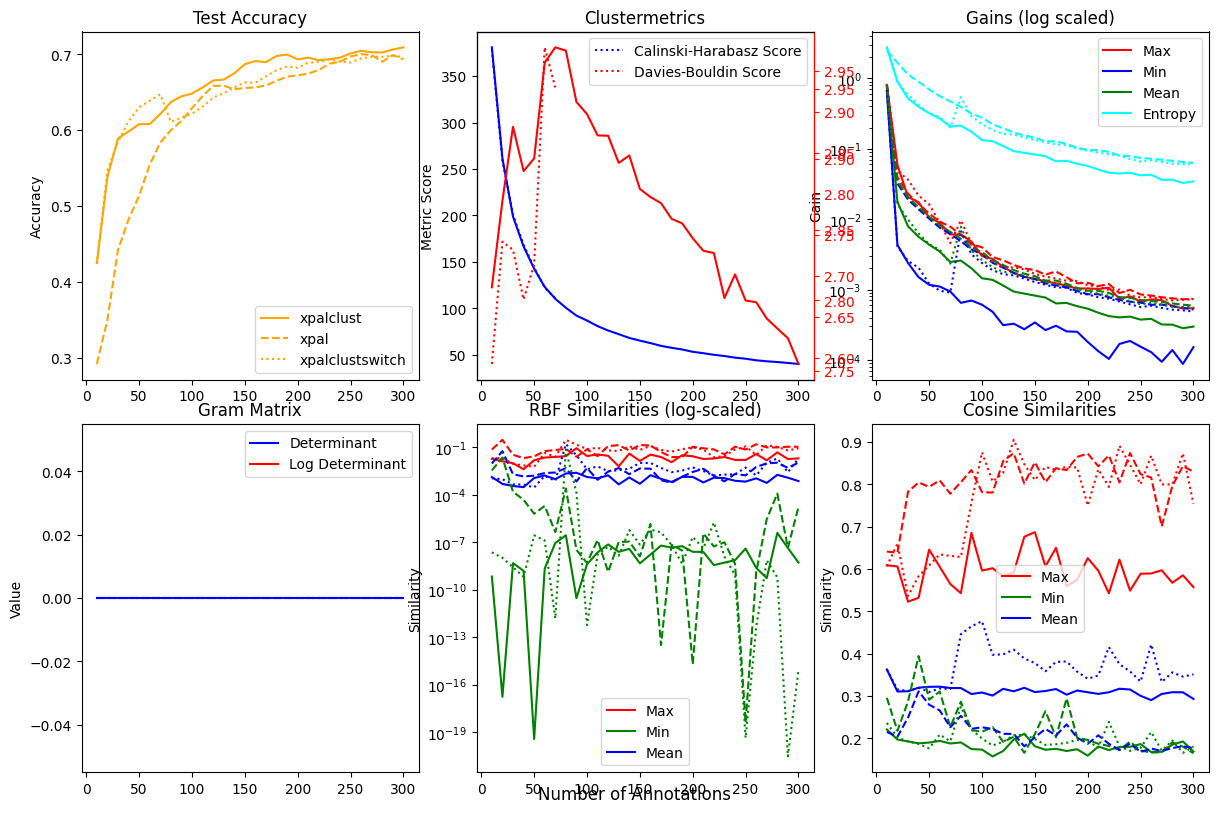

In [5]:
plot_strategy_metrics(result_list, strategy_metric_list)